# Assumptions about SIRDS model
We check patterns of Rt time series across outbreaks in the first and other outbreaks.
We note that when changing the R0 during the first outbreak, there is an interval of similarities to determine the reduction of the R0.
We also note that the secondary outbreaks are similar in a bell shape, and the similarity measure about the left-side and right-side of the bell curve can determine change in R0.
We also note a pattern of the peak flattening measure, but, we decide to ignore it in our model.

In [1]:
from detecta import detect_onset

import util
from sirds_model import sirds_model_fuzzy, get_fuzzy_effective_reproduction_number, get_epidemic_periods_for_beta_transition_fuzzy_variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastdtw import fastdtw
import seaborn as sns
import matplotlib.ticker as mticker
from PIL import Image

## Loading data

In [2]:
df_ts_epidemic_episodes = pd.read_csv('data/output/df_ts_epidemic_episodes.csv', index_col=0)
df_ts_epidemic_episodes.DATA = pd.to_datetime(df_ts_epidemic_episodes.DATA)
df_ts_epidemic_episodes_other_countries = pd.read_csv('data/output/df_ts_epidemic_episodes_other_countries.csv', index_col=0)
df_ts_epidemic_episodes_other_countries.date = pd.to_datetime(df_ts_epidemic_episodes_other_countries.date)

In [3]:
PERIOD = 1095
DAYS_TO_RECOVERY = 8
INITIAL_INFECTED_POPULATION = 0.136537

## Whitout change R0

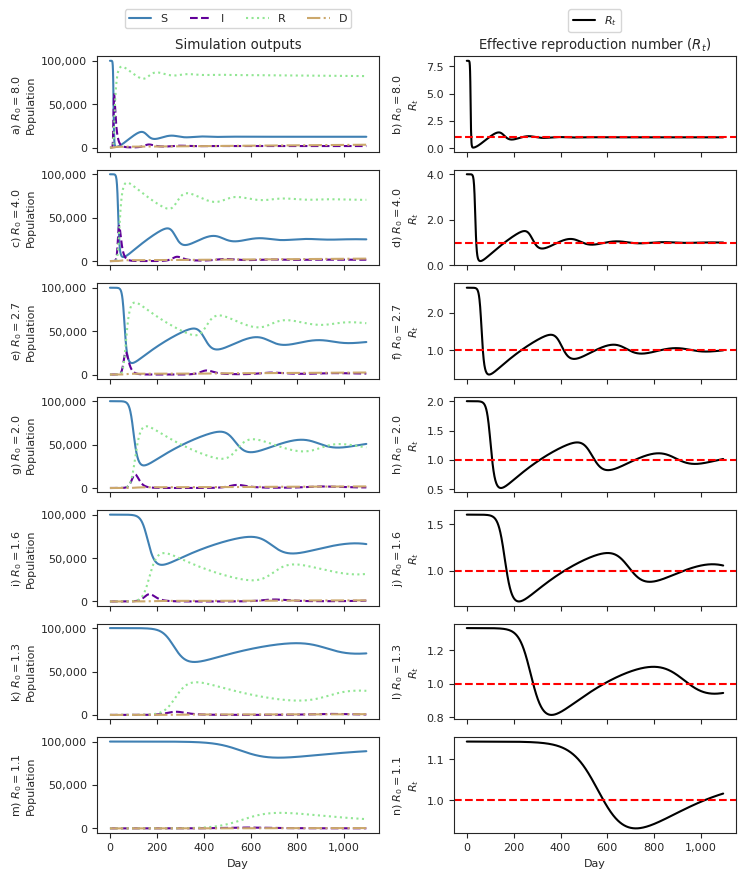

In [4]:
df_without_change_r0 = pd.DataFrame()

line_styles= [ '-', '--', ':', '-.', '-']    
plt.rc('font', size=8)
sns.set_style("ticks")
sns.set_palette(util.get_default_colors_categorical_seaborn())
chart_ids = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']

fig, ax = plt.subplots(7, 2, figsize=(util.centimeter_to_inch(19.05), util.centimeter_to_inch(22.23)), sharex=True)
points = np.linspace(0, PERIOD-1, PERIOD)

for days_between_infections in np.arange(1, 8, 0.1):   
    days_between_infections = round(days_between_infections,1)
    y =  sirds_model_fuzzy(tuple([*[
        INITIAL_INFECTED_POPULATION,
        PERIOD,
        days_between_infections,
        DAYS_TO_RECOVERY, 
        [], 0.01, 365]]))
    S, I, R, D, I_accumulated = y
       
    epidemic_periods_with_fast_transition_fuzzy_variable = get_epidemic_periods_for_beta_transition_fuzzy_variable(PERIOD, [], [])

    SIRDS_effective_reproduction_number = get_fuzzy_effective_reproduction_number(S, 100000, tuple([*[
    DAYS_TO_RECOVERY,
    (epidemic_periods_with_fast_transition_fuzzy_variable, [days_between_infections])]]))
    
    df_temp = pd.DataFrame({'effective_reproduction_number': SIRDS_effective_reproduction_number})
    df_temp['days_between_infections'] = days_between_infections
    df_temp['basic_reproduction_number'] = DAYS_TO_RECOVERY/days_between_infections
    
    onset_rt = detect_onset(df_temp.effective_reproduction_number, threshold=1, n_above=7, n_below=7, show=False)
    for i in range(len(onset_rt)):
        outbreak = i
        
        # When the begin isn't classified as outbreak
        if onset_rt[0][0] > 0: 
            outbreak += 1
            
        if onset_rt[i][1] < (PERIOD-1):
            df_temp.loc[onset_rt[i][0]:onset_rt[i][1],'outbreak'] = outbreak    
    
    df_without_change_r0 = pd.concat([df_without_change_r0, df_temp])
    
    if int(days_between_infections) == days_between_infections:
        r0 = DAYS_TO_RECOVERY/days_between_infections
        i = int(days_between_infections) - 1
        first = (i == 0)
        # Plot the data on three separate curves for S(t), I(t), R(t) and D(t)
        sns.lineplot(x=points, y=S, label='S', color=util.get_default_colors_categorical_seaborn()[1], legend=first, linestyle=line_styles[0], ax=ax[i][0])
        sns.lineplot(x=points, y=I, label='I', color=util.get_default_colors_categorical_seaborn()[2], legend=first, linestyle=line_styles[1], ax=ax[i][0])
        sns.lineplot(x=points, y=R, label='R', color=util.get_default_colors_categorical_seaborn()[4], legend=first, linestyle=line_styles[2], ax=ax[i][0])
        sns.lineplot(x=points, y=D, label='D', color=util.get_default_colors_categorical_seaborn()[3], legend=first, linestyle=line_styles[3], ax=ax[i][0])
        ax[i][0].set_xlabel('Day')        
        ax[i][0].set_ylabel(chart_ids[i*2]+') $R_{0} = $'+str(round(r0,1))+'\nPopulation')
        ax[i][0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax[i][0].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
        sns.lineplot(x=points, y=SIRDS_effective_reproduction_number, color='black', label='$R_{t}$', legend=first, ax=ax[i][1])
        ax[i][1].axhline(1, color='red', linestyle='--')        
        ax[i][1].set_ylabel(chart_ids[i*2+1]+') $R_{0} = $'+str(round(r0,1))+'\n$R_{t}$')
        ax[i][1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(round(x, 1), ',')))
        ax[i][1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax[i][1].set_xlabel('Day')
        
        if first:
            ax[0][0].set_title('Simulation outputs')
            ax[0][1].set_title('Effective reproduction number ($R_{t}$)')            
            ax[0][0].legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.55))
            ax[0][1].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, 1.55))
plt.tight_layout()
filename = 'images/simulation'
plt.savefig(filename + '.pdf', bbox_inches="tight", transparent=True)
plt.savefig(filename + '.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
img = Image.open(filename + ".tiff")
img.save(filename + "_compressed.tiff", compression="tiff_lzw")
plt.show()

## Changing R0 in first outbreak

In [5]:
outbreak_zero = 0

df_with_change_r0_in_first_outbreak = pd.DataFrame()

for days_between_infections in np.arange(1, 8, 0.1):
    
    df_first_outbreak = df_without_change_r0[(df_without_change_r0.days_between_infections == days_between_infections) & (df_without_change_r0.outbreak == 0)]
    size_first_outbreak = len(df_first_outbreak)
    
    for breakpoint_factor in [0.25, 0.5, 0.75]:
        breakpoint = int(size_first_outbreak) * breakpoint_factor
        
        for days_between_infections_factor in np.arange(1.1, 2, 0.1):
            days_between_infections_factor = round(days_between_infections_factor, 1)
            new_days_between_infections = days_between_infections * days_between_infections_factor
            
            for days_to_transition in [0, 7, 14, 21, 28, 35, 42, 49, 56]:            
                y =  sirds_model_fuzzy(tuple([*[
                    INITIAL_INFECTED_POPULATION,
                    PERIOD,
                    days_between_infections,
                    DAYS_TO_RECOVERY, 
                    [], 0.01, 365, new_days_between_infections, breakpoint, days_to_transition]]))
                S, I, R, D, I_accumulated = y
                   
                epidemic_periods_with_fast_transition_fuzzy_variable = get_epidemic_periods_for_beta_transition_fuzzy_variable(PERIOD, [breakpoint], [days_to_transition])
            
                SIRDS_effective_reproduction_number = get_fuzzy_effective_reproduction_number(S, 100000, tuple([*[
                DAYS_TO_RECOVERY,
                (epidemic_periods_with_fast_transition_fuzzy_variable, [days_between_infections, new_days_between_infections])]]))
                
                df_temp = pd.DataFrame({'effective_reproduction_number': SIRDS_effective_reproduction_number})
                df_temp['days_between_infections'] = days_between_infections
                df_temp['basic_reproduction_number'] = DAYS_TO_RECOVERY/days_between_infections
                df_temp['days_between_infections_factor'] = days_between_infections_factor
                df_temp['days_between_infections_1'] = new_days_between_infections
                df_temp['basic_reproduction_number_1'] = DAYS_TO_RECOVERY/new_days_between_infections
                df_temp['breakpoint_factor'] = breakpoint_factor
                df_temp['breakpoint_1'] = breakpoint
                df_temp['days_to_transition_1'] = days_to_transition
                
                onset_rt = detect_onset(df_temp.effective_reproduction_number, threshold=1, n_above=7, n_below=7, show=False)
                for i in range(len(onset_rt)):
                    if onset_rt[i][1] < (PERIOD-1):
                        df_temp.loc[onset_rt[i][0]:onset_rt[i][1],'outbreak'] = i    
                
                df_with_change_r0_in_first_outbreak = pd.concat([df_with_change_r0_in_first_outbreak, df_temp])

## Checking the outbreak properties

### First outbreak similarities

In [6]:
df_similarity_first_outbreak = pd.DataFrame()
for days_between_infections in df_with_change_r0_in_first_outbreak.days_between_infections.unique():
    for breakpoint_factor in df_with_change_r0_in_first_outbreak.breakpoint_factor.unique():
        for days_between_infections_factor in df_with_change_r0_in_first_outbreak.days_between_infections_factor.unique():
            for days_to_transition in df_with_change_r0_in_first_outbreak.days_to_transition_1.unique():
                df_temp = df_with_change_r0_in_first_outbreak[(df_with_change_r0_in_first_outbreak.days_between_infections == days_between_infections) & (df_with_change_r0_in_first_outbreak.breakpoint_factor == breakpoint_factor) & (df_with_change_r0_in_first_outbreak.days_between_infections_factor == days_between_infections_factor) & (df_with_change_r0_in_first_outbreak.days_to_transition_1 == days_to_transition)]
                effective_R0 = df_temp.effective_reproduction_number.iloc[0]
                estimated_days_between_infections = round(DAYS_TO_RECOVERY/effective_R0, 1)
                
                df_reference = df_without_change_r0[(df_without_change_r0.days_between_infections == estimated_days_between_infections)]
                
                if (len(df_temp[df_temp.outbreak == 0]) > 0) & (len(df_reference[df_reference.outbreak == 0]) > 0):                
                    distance, path = fastdtw(df_reference[df_reference.outbreak == 0].effective_reproduction_number, df_temp[df_temp.outbreak == 0].effective_reproduction_number)
    
                    # print('days_between_infections: '+str(days_between_infections))
                    # print('days_between_infections_factor: '+str(days_between_infections_factor))
                    # print('estimated_days_between_infections: '+str(estimated_days_between_infections))
                    # print('effective_R0: '+str(effective_R0))
                    # print(f"DTW distance between the time series: {distance}")
                    
                    dict_similarity = {'days_between_infections': days_between_infections, 'breakpoint_factor': breakpoint_factor, 'days_between_infections_factor': days_between_infections_factor, 'days_to_transition': days_to_transition, 'effective_R0': effective_R0, 'estimated_days_between_infections': estimated_days_between_infections, 'DTW_distance': distance}
                    
                    df_similarity_first_outbreak = pd.concat([df_similarity_first_outbreak, pd.DataFrame.from_records([dict_similarity])])

In [7]:
len(df_with_change_r0_in_first_outbreak)

18625950

In [8]:
len(df_without_change_r0)

76650

In [9]:
df_similarity_first_outbreak.DTW_distance.describe()

count    11343.000000
mean         3.603442
std          5.623339
min          0.215094
25%          1.082944
50%          1.716371
75%          3.014590
max         49.356827
Name: DTW_distance, dtype: float64

In [10]:
df_similarity_first_outbreak.groupby('estimated_days_between_infections').describe()['DTW_distance']

,count,mean,std,min,25%,50%,75%,max
estimated_days_between_infections,,,,,,,,
1.0,78.0,5.981781,2.492183,1.847446,4.072317,6.303420,6.827505,14.980573
1.1,125.0,4.847149,2.302858,1.172493,3.054228,4.787567,6.251079,13.283500
1.2,101.0,3.836031,1.834512,0.823397,2.532143,3.547254,5.281923,8.233943
1.3,142.0,3.585196,1.329606,1.443235,2.602997,3.437547,4.552857,7.727390
1.4,170.0,3.570082,1.676714,0.769589,2.370160,3.739452,4.418768,10.569404
...,...,...,...,...,...,...,...,...
7.0,156.0,1.809429,3.165315,0.274827,0.519143,1.080039,1.488613,18.511152
7.1,138.0,2.256009,2.797926,0.275733,0.986628,1.731010,2.409526,14.922111
7.2,87.0,1.419081,1.068018,0.286444,0.549497,0.931709,2.777880,3.647679


### Checking the similarities subsequent outbreaks

In [11]:
def similarity(time_series, plot):   
    peak_index = np.argmax(time_series)
    sum_left_side = np.sum(time_series[:peak_index])
    sum_right_side = np.sum(time_series[peak_index+1:])
        
    if plot:
        plt.plot(time_series)        
        plt.axvline(peak_index, color='red')
        plt.show()
    
    return (sum_right_side-sum_left_side)/(sum_right_side+sum_left_side)    

def peak_flattening(time_series, plot):
    peak = np.max(time_series)
    bottom = np.min(time_series)
    amplitude = peak - bottom
    
    top_line = bottom + amplitude * 0.75
    
    size_top_side = len(time_series[time_series>top_line])
    size = len(time_series)
    
    if plot:
        plt.plot(time_series)                
        plt.axhline(top_line, color='red')
        plt.show()
        
    return size_top_side/size

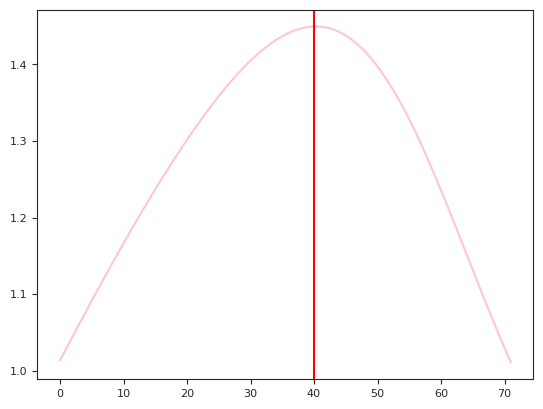

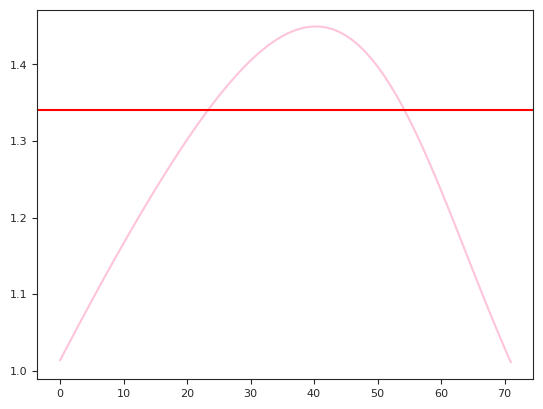

days_between_infections: 1.0 - outbreak: 1.0
outbreak_similarity: -0.12428902803956048
outbreak_peak_flattening: 0.4305555555555556


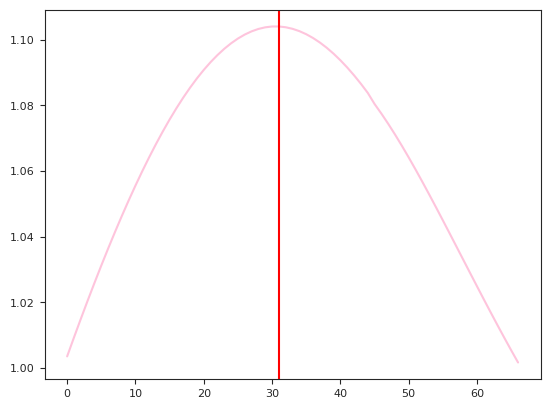

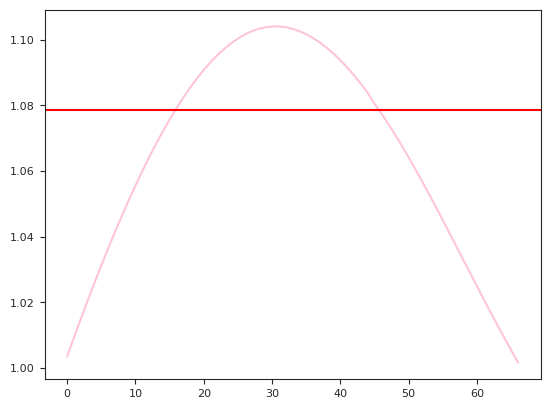

days_between_infections: 1.0 - outbreak: 2.0
outbreak_similarity: 0.058010766875260605
outbreak_peak_flattening: 0.44776119402985076


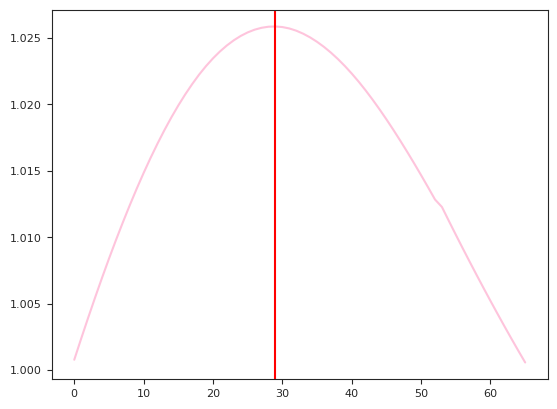

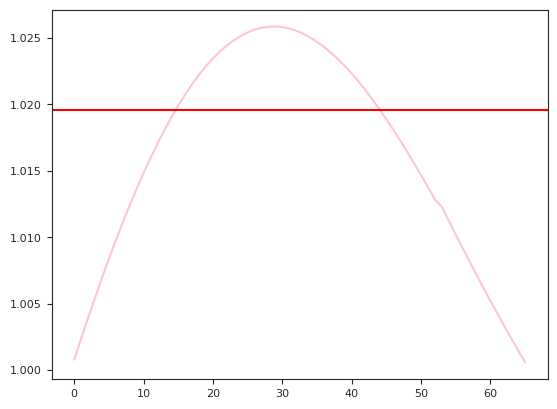

days_between_infections: 1.0 - outbreak: 3.0
outbreak_similarity: 0.10702303522446725
outbreak_peak_flattening: 0.45454545454545453


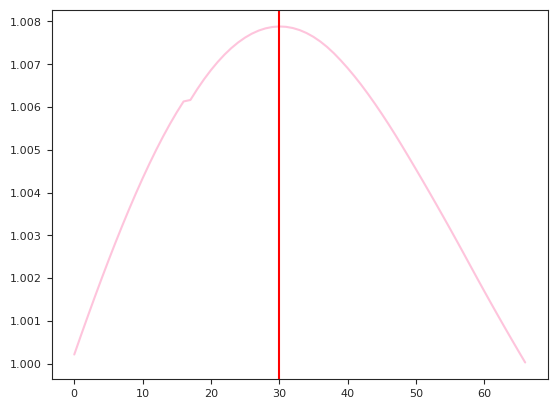

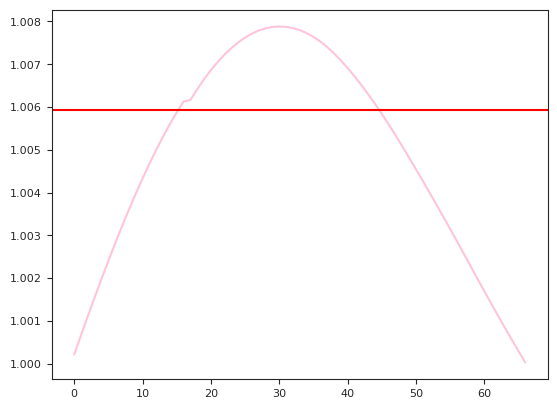

days_between_infections: 1.0 - outbreak: 4.0
outbreak_similarity: 0.09067794389016234
outbreak_peak_flattening: 0.43283582089552236


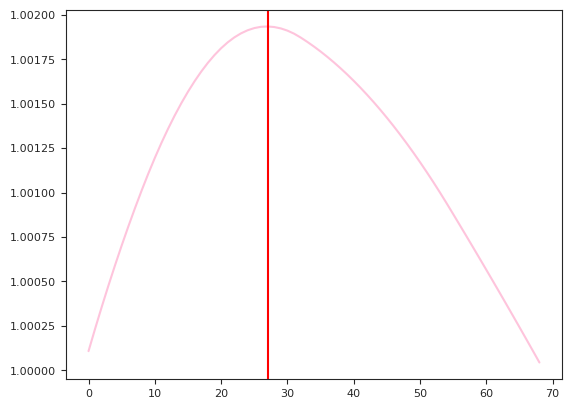

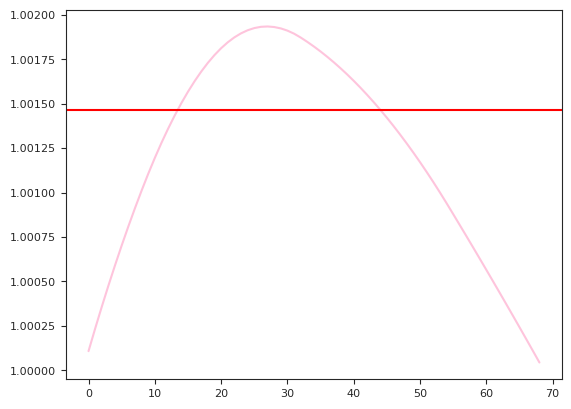

days_between_infections: 1.0 - outbreak: 5.0
outbreak_similarity: 0.20582879767952736
outbreak_peak_flattening: 0.4492753623188406


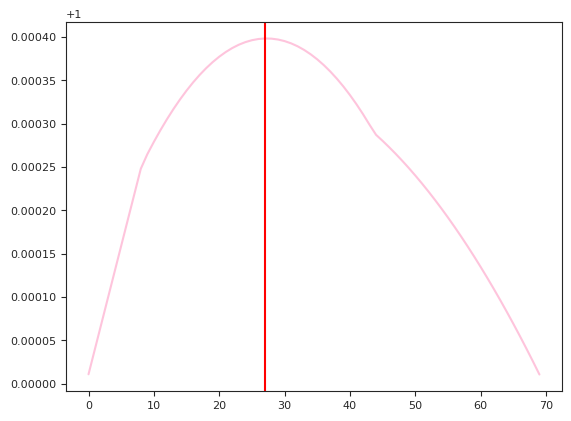

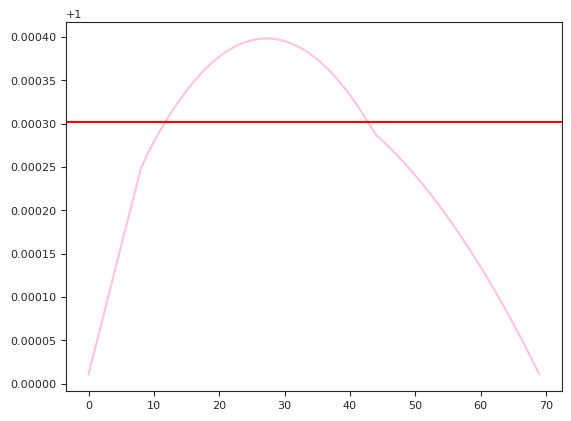

days_between_infections: 1.0 - outbreak: 6.0
outbreak_similarity: 0.21737451767089883
outbreak_peak_flattening: 0.44285714285714284


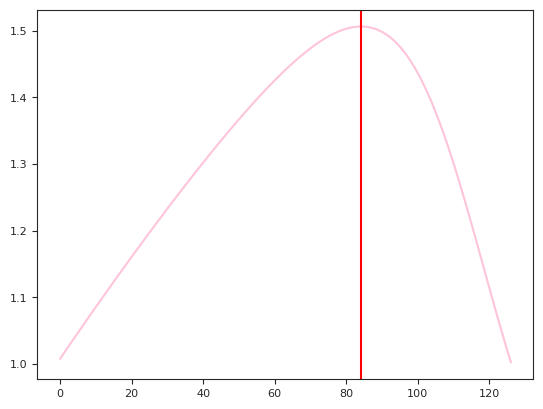

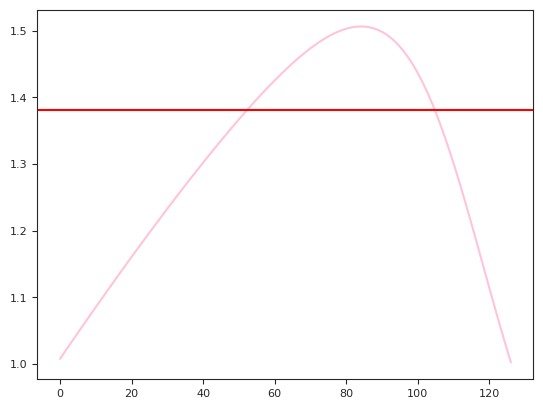

days_between_infections: 2.0 - outbreak: 1.0
outbreak_similarity: -0.32322523753727667
outbreak_peak_flattening: 0.4094488188976378


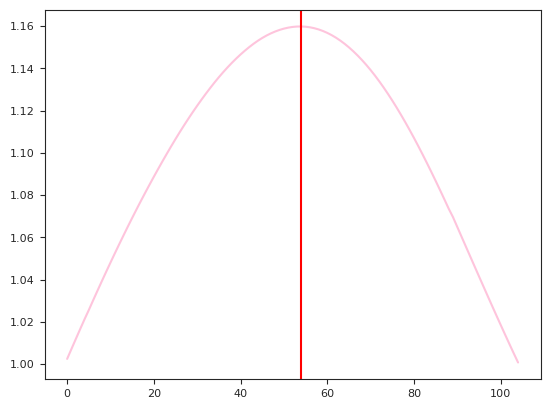

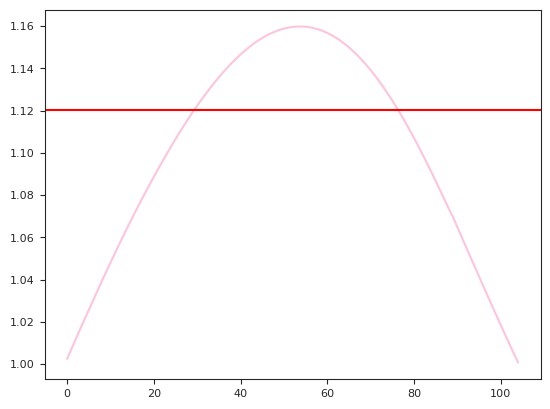

days_between_infections: 2.0 - outbreak: 2.0
outbreak_similarity: -0.03961714922935571
outbreak_peak_flattening: 0.44761904761904764


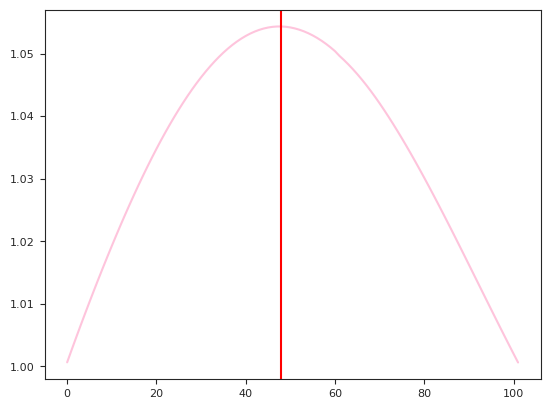

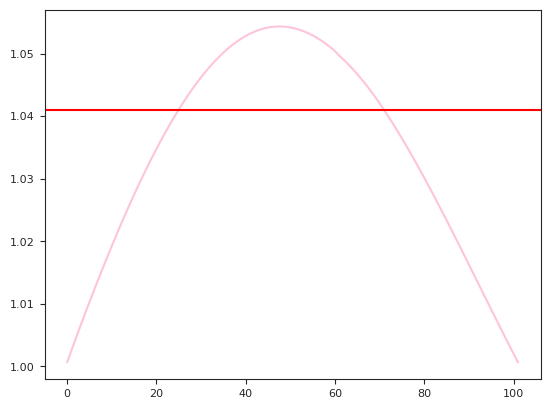

days_between_infections: 2.0 - outbreak: 3.0
outbreak_similarity: 0.04859271981375531
outbreak_peak_flattening: 0.46078431372549017


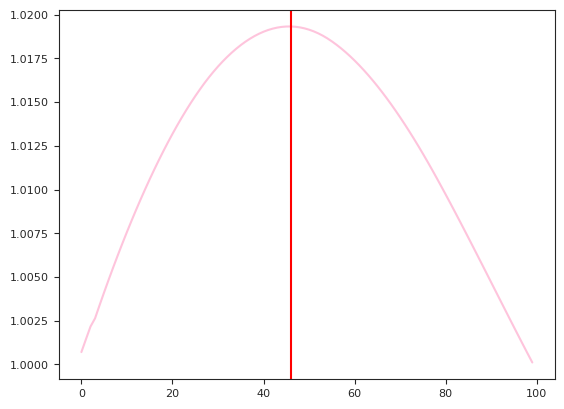

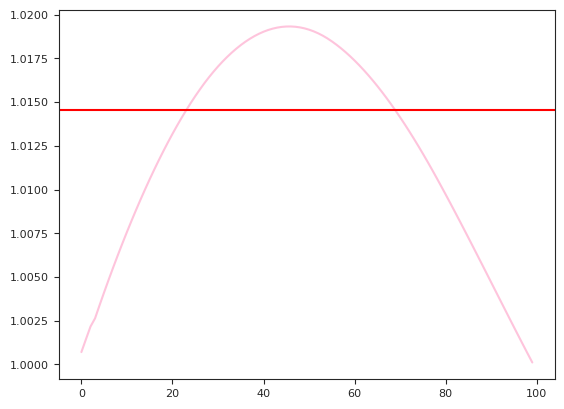

days_between_infections: 2.0 - outbreak: 4.0
outbreak_similarity: 0.07021483445138701
outbreak_peak_flattening: 0.46


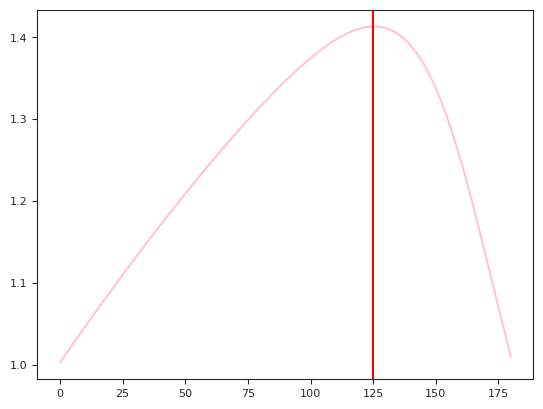

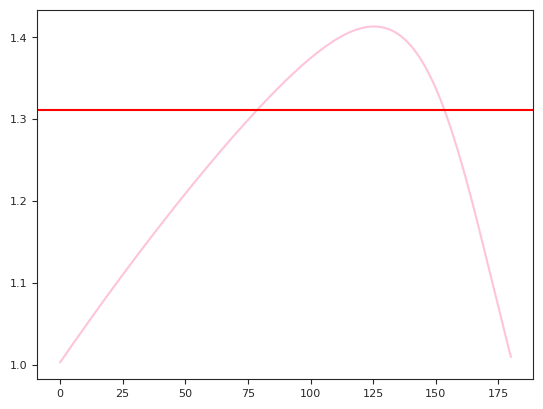

days_between_infections: 3.0 - outbreak: 1.0
outbreak_similarity: -0.37695191645203635
outbreak_peak_flattening: 0.4143646408839779


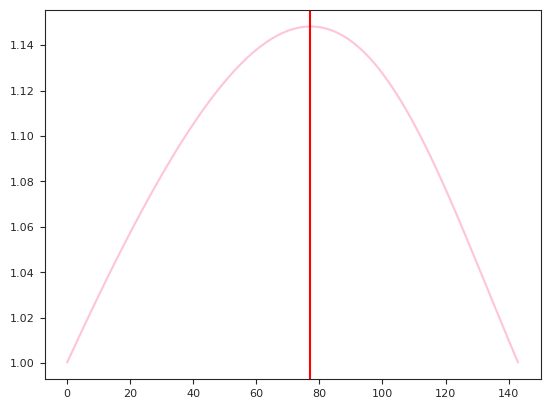

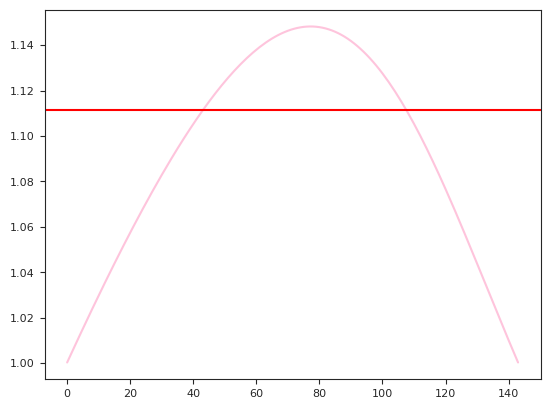

days_between_infections: 3.0 - outbreak: 2.0
outbreak_similarity: -0.07636341952620566
outbreak_peak_flattening: 0.4513888888888889


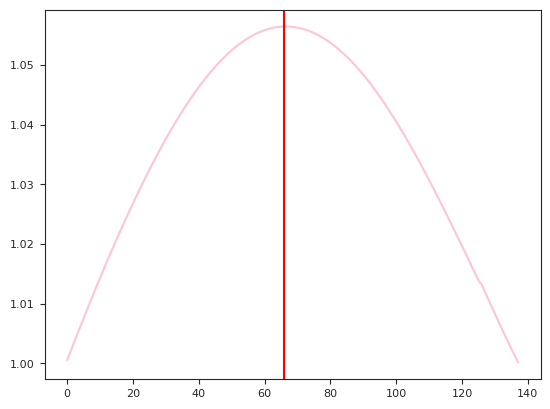

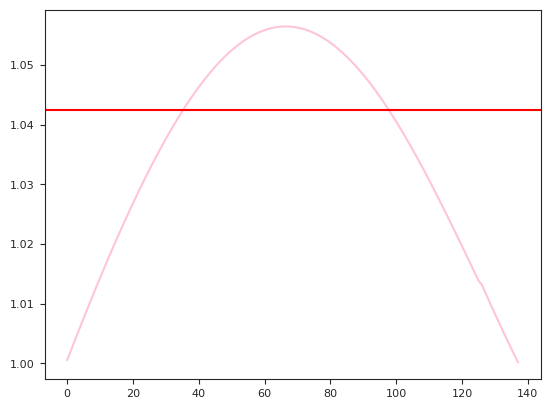

days_between_infections: 3.0 - outbreak: 3.0
outbreak_similarity: 0.03601874945557014
outbreak_peak_flattening: 0.4492753623188406


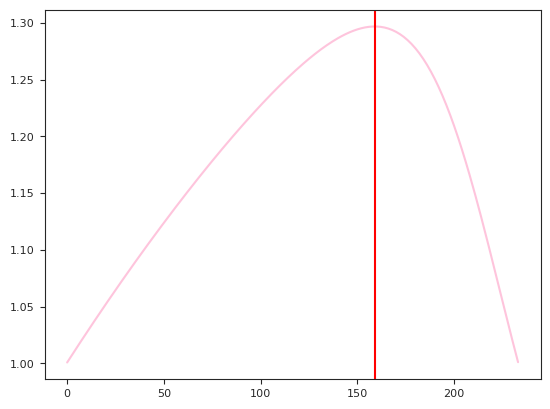

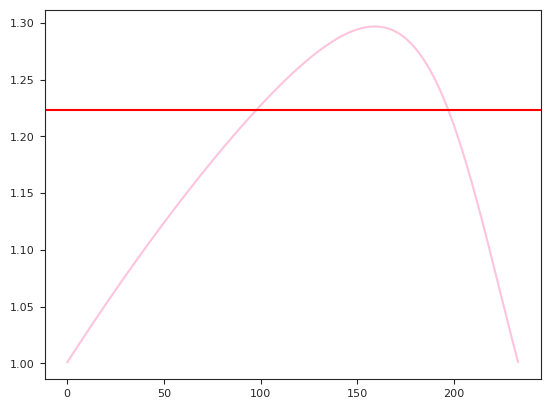

days_between_infections: 4.0 - outbreak: 1.0
outbreak_similarity: -0.3570547566661859
outbreak_peak_flattening: 0.42735042735042733


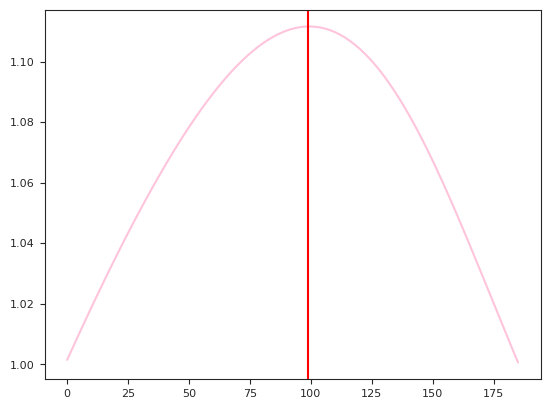

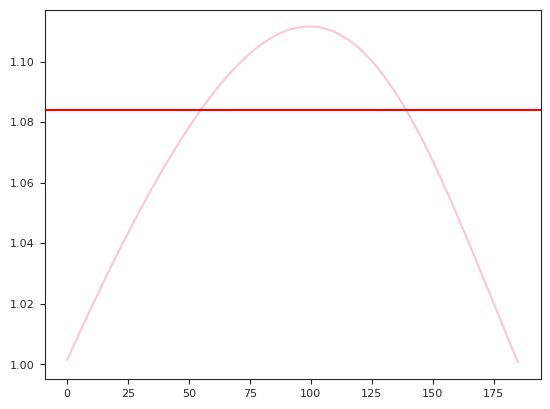

days_between_infections: 4.0 - outbreak: 2.0
outbreak_similarity: -0.06997974673363135
outbreak_peak_flattening: 0.45698924731182794


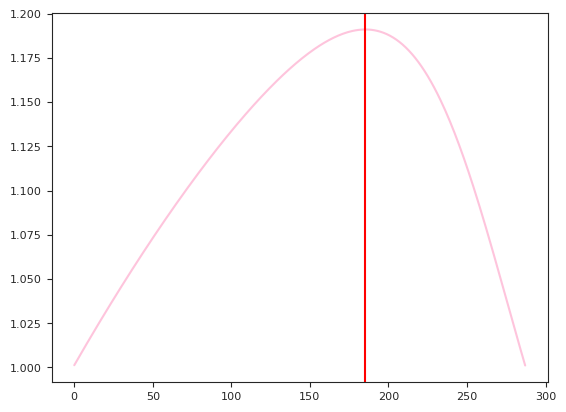

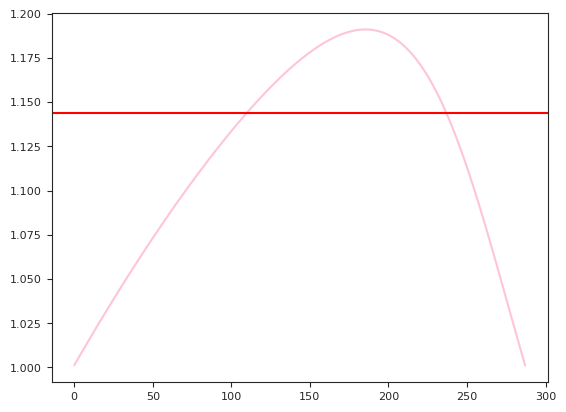

days_between_infections: 5.0 - outbreak: 1.0
outbreak_similarity: -0.28483275179411766
outbreak_peak_flattening: 0.4409722222222222


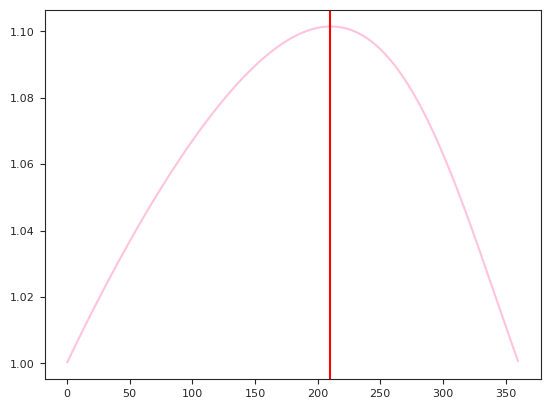

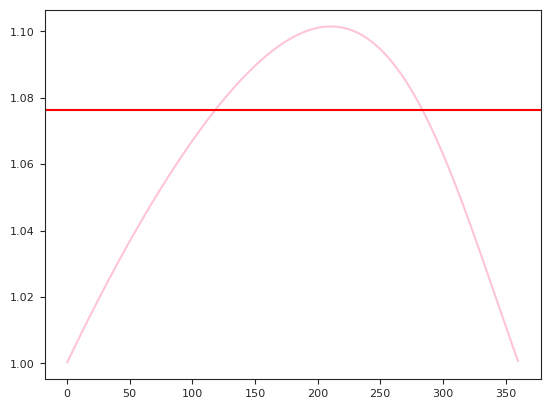

days_between_infections: 6.0 - outbreak: 1.0
outbreak_similarity: -0.16537169152712863
outbreak_peak_flattening: 0.4598337950138504


In [12]:
df_secundary_outbreak_properties = pd.DataFrame()
for days_between_infections in df_without_change_r0.days_between_infections.unique():
    df_temp = df_without_change_r0[df_without_change_r0.days_between_infections == days_between_infections]
    for outbreak in df_temp[df_temp.outbreak > 0].outbreak.unique():
        df_outbreak = df_temp[df_temp.outbreak == outbreak]
        
        if days_between_infections == int(days_between_infections):
            plot = True
        else:
            plot = False
            
        outbreak_similarity = similarity(df_outbreak.effective_reproduction_number.values, plot)
        outbreak_peak_flattening =  peak_flattening(df_outbreak.effective_reproduction_number.values, plot)
                
        if plot:
            print(f'days_between_infections: {str(days_between_infections)} - outbreak: {str(outbreak)}')
            
            print('outbreak_similarity: '+str(outbreak_similarity))
            print('outbreak_peak_flattening: '+str(outbreak_peak_flattening))
                
        dict_temp = {'days_between_infections': days_between_infections, 'outbreak': outbreak, 'outbreak_similarity': outbreak_similarity, 'outbreak_peak_flattening': outbreak_peak_flattening}
        
        df_secundary_outbreak_properties = pd.concat([df_secundary_outbreak_properties, pd.DataFrame.from_records([dict_temp])])
        

In [13]:
df_secundary_outbreak_properties.describe()[['outbreak_similarity', 'outbreak_peak_flattening']]

,outbreak_similarity,outbreak_peak_flattening
count,149.000000,149.000000
mean,-0.086605,0.444080
std,0.175847,0.016526
min,-0.381501,0.386667
25%,-0.262865,0.433962
50%,-0.061271,0.450000
75%,0.071259,0.455224
max,0.217375,0.465116


### Plotting charts

In [14]:
sns.set_style("ticks")
sns.set_palette("gray")
plt.rc('font', size=8)

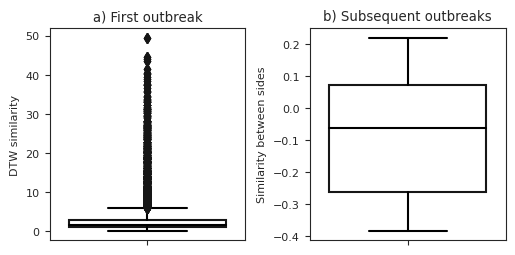

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(util.centimeter_to_inch(13.2), util.centimeter_to_inch(6.6)))

# Create a boxplot with white faces
boxplot = sns.boxplot(y=df_similarity_first_outbreak.DTW_distance, ax=ax[0], boxprops=dict(facecolor='white'))
plt.setp(ax[0].lines, color='black')
plt.setp(ax[0].artists, edgecolor = 'black')
ax[0].set_title('a) First outbreak')
ax[0].set_ylabel('DTW similarity')   

boxplot = sns.boxplot(y=df_secundary_outbreak_properties.outbreak_similarity, ax=ax[1], boxprops=dict(facecolor='white'))
plt.setp(ax[1].lines, color='black')
plt.setp(ax[1].artists, edgecolor = 'black')
ax[1].set_title('b) Subsequent outbreaks')
ax[1].set_ylabel('Similarity between sides')

plt.tight_layout()

plt.savefig('images/similarity_outbreaks.pdf', bbox_inches="tight")
plt.savefig('images/similarity_outbreaks.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
img = Image.open("images/similarity_outbreaks.tiff")
img.save("images/similarity_outbreaks_compressed.tiff", compression="tiff_lzw")
plt.show()

## Testing for Brazil data

### First outbreak

In [16]:
df_brazil_first_outbreak = df_ts_epidemic_episodes[df_ts_epidemic_episodes.ONSET_NUMERO_REPRODUCAO_EFETIVO_MEDIA == 0]
r0_brazil = df_brazil_first_outbreak.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA.max()

In [17]:
estimated_days_between_infections = round(DAYS_TO_RECOVERY/r0_brazil, 1)

df_reference = df_without_change_r0[(df_without_change_r0.days_between_infections == estimated_days_between_infections)]
              
distance, path = fastdtw(df_reference[df_reference.outbreak == 0].effective_reproduction_number, df_brazil_first_outbreak.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA)

In [18]:
print(distance)

1.7271893220061754


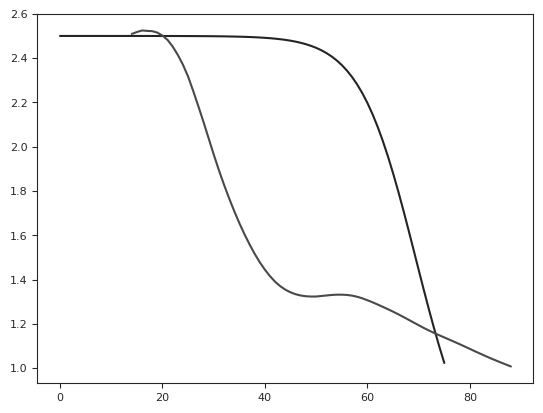

In [19]:
plt.plot(df_reference[df_reference.outbreak == 0].effective_reproduction_number)
plt.plot(df_brazil_first_outbreak.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA)
plt.show()

### From the second outbreak onwards

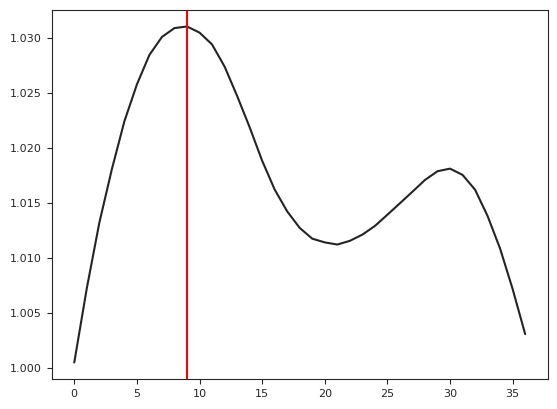

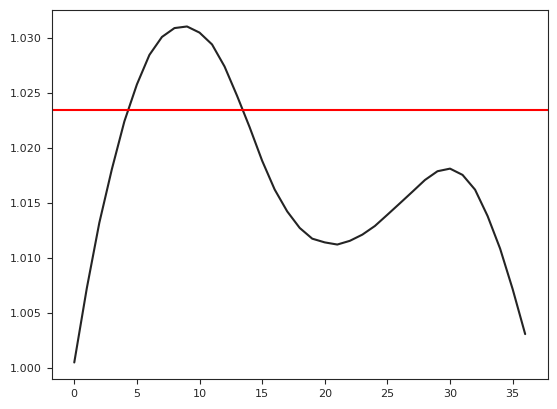

outbreak: 1.0 - similarity: 0.4987 - peak flattening: 0.2432


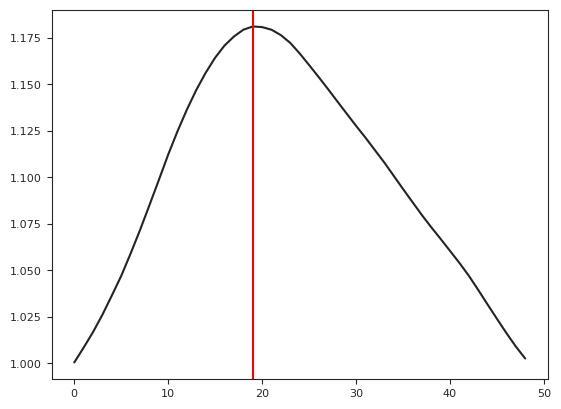

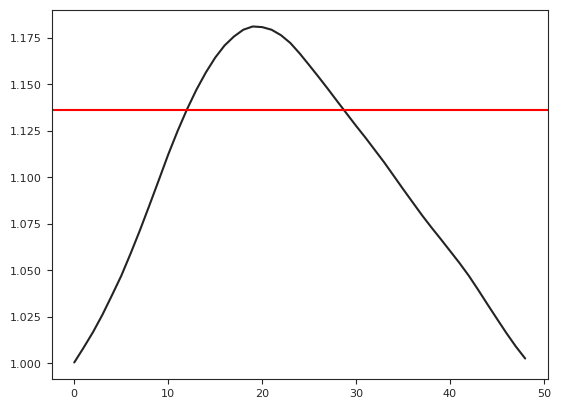

outbreak: 2.0 - similarity: 0.2098 - peak flattening: 0.3469


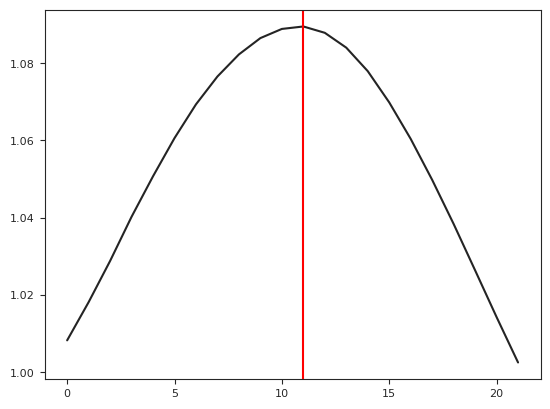

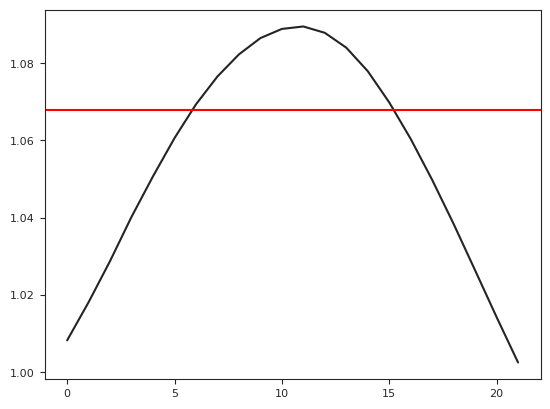

outbreak: 3.0 - similarity: -0.0497 - peak flattening: 0.4545


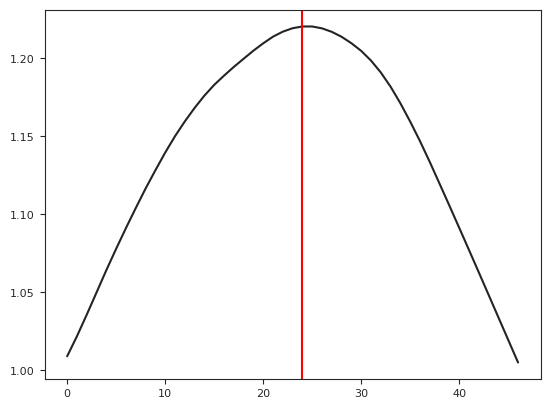

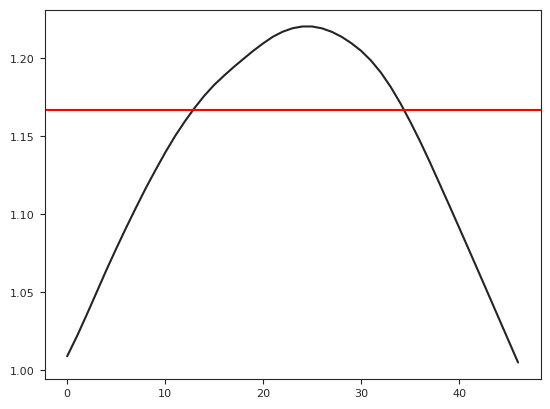

outbreak: 4.0 - similarity: -0.0438 - peak flattening: 0.4681


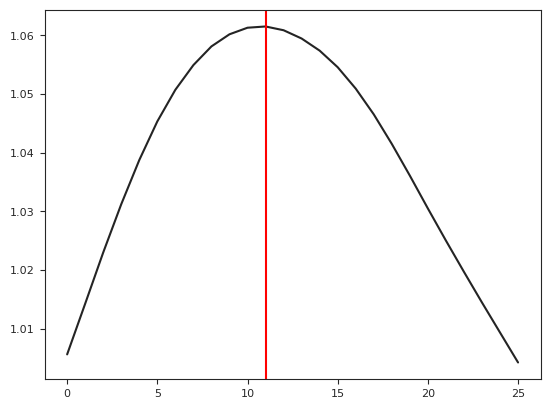

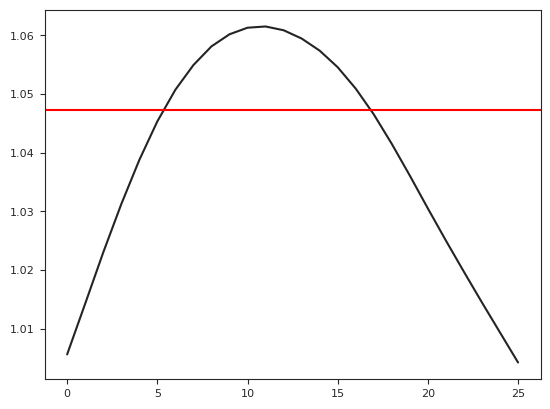

outbreak: 5.0 - similarity: 0.1182 - peak flattening: 0.4231


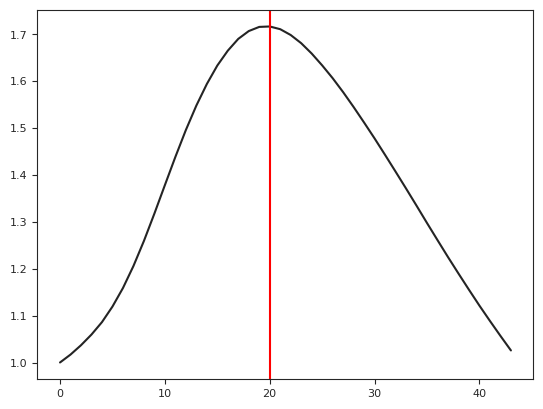

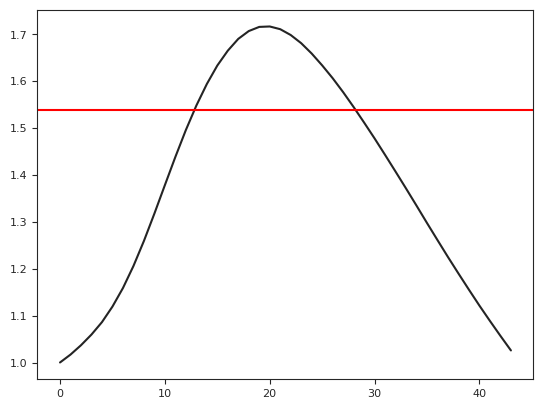

outbreak: 6.0 - similarity: 0.0836 - peak flattening: 0.3636


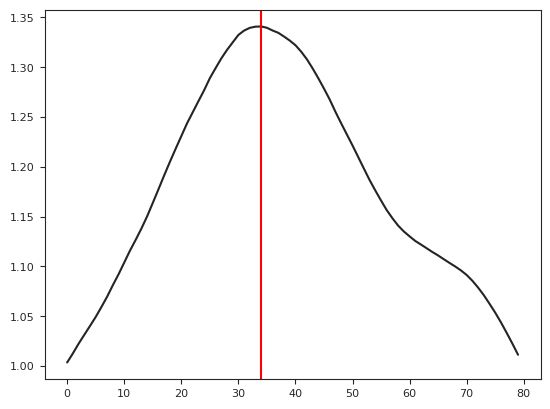

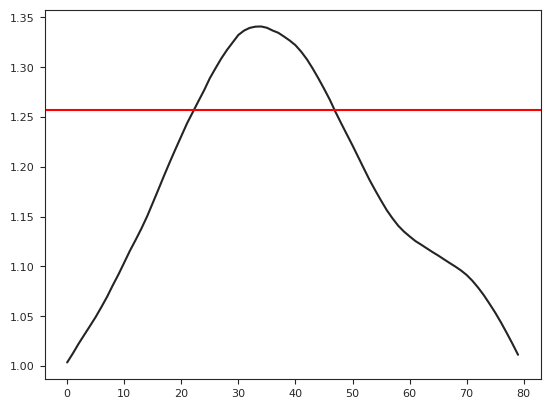

outbreak: 7.0 - similarity: 0.1363 - peak flattening: 0.3


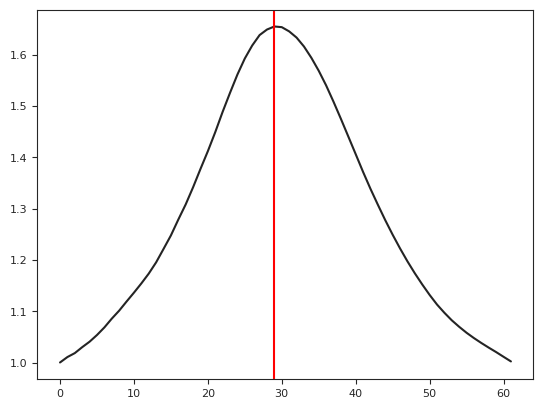

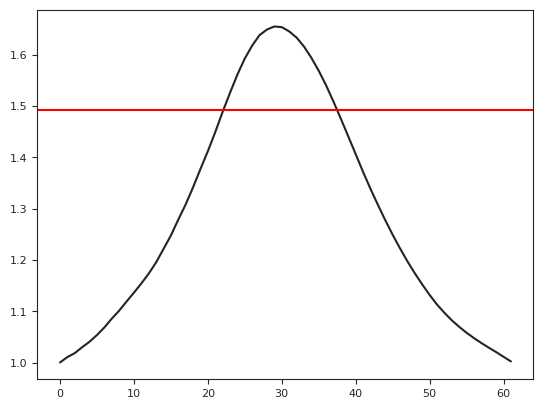

outbreak: 8.0 - similarity: 0.0536 - peak flattening: 0.2419


In [20]:
for outbreak in df_ts_epidemic_episodes[df_ts_epidemic_episodes.ONSET_NUMERO_REPRODUCAO_EFETIVO_MEDIA > 0].ONSET_NUMERO_REPRODUCAO_EFETIVO_MEDIA.unique():
    df_temp = df_ts_epidemic_episodes[df_ts_epidemic_episodes.ONSET_NUMERO_REPRODUCAO_EFETIVO_MEDIA == outbreak]
    outbreak_similarity = similarity(df_temp.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA.values, True)
    outbreak_peak_flattening = peak_flattening(df_temp.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA.values, True)
    print(f'outbreak: {str(outbreak)} - similarity: {str(round(outbreak_similarity, 4))} - peak flattening: {str(round(outbreak_peak_flattening, 4))}')